# CAMERA Workshop 2019

Daniela Ushizima, Alexandre de Siqueira, Stéfan van der Walt

_BIDS @ University of California, Berkeley_

_Lawrence Berkeley National Laboratory - LBNL_

* Support material for the tutorial _Image processing for microCT using scikit-image (Part II)_.

This tutorial will introduce how to analyze three dimensional stacked and volumetric
images in Python, mainly using scikit-image. Here we will learn how to:
  * pre-process data using filtering, binarization and segmentation techniques.
  * inspect, count and measure attributes of objects and regions of interest in the data.
  * visualize 3D data.

Please prepare for the tutorial by [installing the pre-requisite software](preparation.md) beforehand.

For more info:
  * [[CAMERA Workshop 2019]](http://microct.lbl.gov/cameratomo2019/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from skimage import io

In [3]:
input_filename="../data/bead_pack_artifacts_small.tif"
img = io.imread(input_filename)

In [4]:
from ipywidgets import interact,IntSlider
def slicing(b,lut='viridis'):
    def slicer(z):
        plt.imshow(b[z,:,:],cmap=lut, vmin=np.min(b), vmax=np.max(b)) #without vmin/vmax = dynamic :(
    interact(slicer, z=IntSlider(min=0,max=len(b)-1,step=1,value=len(b)//2));

# Image segmentation:
- image transformations for more suitable image representation
- beyond thresholding: supervised and unsupervised machine learning
- skimage [segmentation](https://scikit-image.org/docs/dev/api/skimage.segmentation.html)
- sklearn [segmentation](https://scikit-learn.org/stable/modules/clustering.html#spectral-clustering)

## Euclidean distance transform

In [5]:
#cleaned
input_filename="../data/cleaned.tiff"
cleaned = io.imread(input_filename)

In [6]:
from scipy import ndimage as ndi
edt = ndi.distance_transform_edt(cleaned)

In [7]:
slicing(edt)

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

## Creating markers

In [8]:
from skimage import feature, measure
seeds = feature.peak_local_max(edt, indices = False, footprint=np.ones((3, 3, 3)),
                            labels=measure.label(cleaned)) #return sparse matrix instead of array with peaks

In [9]:
from skimage.morphology import watershed
markers = measure.label(seeds)
labeled_edt = watershed(-edt, markers, mask=cleaned)
print('Estimated number of objects in the stack: '+str(np.max(labeled_edt)))

/Users/dani/anaconda3/envs/dip3d/lib/python3.7/site-packages/skimage/morphology/_deprecated.py:5: skimage_deprecation: Function ``watershed`` is deprecated and will be removed in version 0.19. Use ``skimage.segmentation.watershed`` instead.
  def watershed(image, markers=None, connectivity=1, offset=None, mask=None,


Estimated number of objects in the stack: 246


In [10]:
slicing(labeled_edt,'inferno')

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

## Supervised classification using markers

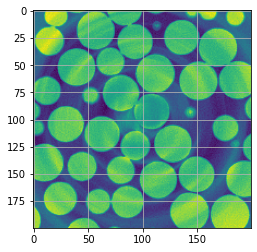

In [11]:
from skimage import segmentation as seg
b = img[len(img)//2,:,:]
plt.imshow(b)
plt.grid()

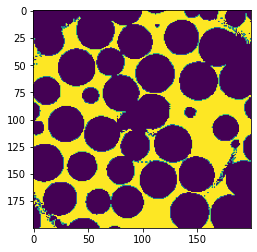

In [12]:
#2D version
markers = (25, 30)  # Experiment with other markers
c = seg.flood(b, markers, tolerance=40)
plt.imshow(c)

In [13]:
#3D version
markers = (len(img)//2, 25, 30)  # Experiment with other markers
c = seg.flood(img, markers, tolerance=40)

In [14]:
from skimage import morphology
aball = morphology.ball(3)
c = morphology.binary_dilation(c,selem=aball) #it's an erosion on the beads!
c = morphology.remove_small_objects(255-c, min_size=5000, connectivity=1, in_place=False)
slicing(c)

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

In [15]:
print('Estimated number of objects in the stack: '+str(np.max(morphology.label(c))))

Estimated number of objects in the stack: 65


## Unsupervised - kmeans

/Users/dani/anaconda3/envs/dip3d/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  This is separate from the ipykernel package so we can avoid doing imports until


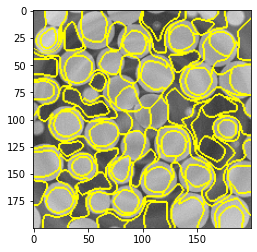

In [38]:
from skimage.segmentation import slic, mark_boundaries
from skimage import restoration
segments = slic(b, n_segments=120, compactness=0.05, enforce_connectivity=True, sigma=5, max_iter=500, multichannel=False) #higher compact = more weight space, more square
plt.imshow(mark_boundaries(b, segments))

/Users/dani/anaconda3/envs/dip3d/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  after removing the cwd from sys.path.


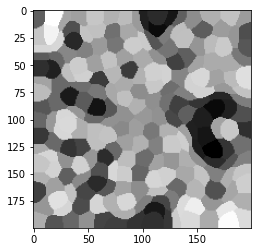

In [17]:
from skimage import color
from skimage.future import graph
aslice = img[len(img)//2,:,:]
output = color.label2rgb(segments, aslice, kind='avg')
plt.imshow(output,cmap='gray')

The routine below can take several minutes depending on your computer configuration

In [18]:
segments = slic(cleaned, n_segments=250, compactness=0.05, enforce_connectivity=True, sigma=10, max_iter=50, multichannel=False) #higher compact = more weight space, more square
output = color.label2rgb(segments, cleaned, kind='avg')

/Users/dani/anaconda3/envs/dip3d/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  """Entry point for launching an IPython kernel.
/Users/dani/anaconda3/envs/dip3d/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The new recommended value for bg_label is 0. Until version 0.19, the default bg_label value is -1. From version 0.19, the bg_label default value will be 0. To avoid this warning, please explicitly set bg_label value.
  


In [19]:
slicing(output)

interactive(children=(IntSlider(value=100, description='z', max=199), Output()), _dom_classes=('widget-interac…

In [20]:
from skimage import img_as_ubyte
o = img_as_ubyte(output)
#view(o, slicing_planes=True,gradient_opacity=0.4)

# Measuring

In [21]:
from skimage import feature, measure

In [22]:
label = measure.label(cleaned)
regions = measure.regionprops(label,intensity_image=img)

In [23]:
np.max(label) #len(regionprops)

166

In [24]:
accum2 = [p.area for p in regions]

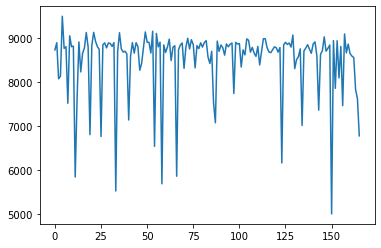

In [25]:
plt.plot(accum2)

In [26]:
area=accum2
convex_area = [p.convex_area for p in regions]
solidity = [p.solidity for p in regions]

In [27]:
type(area)

list

In [28]:
import pandas as pd
beadpd = pd.DataFrame(data = list(zip(area,convex_area,solidity)),
             columns = ['area','convex_area','solidity']
            )

In [29]:
beadpd.to_csv('measurements.csv')

In [30]:
#measurements = measure.regionprops_table(labeled,img,properties=['area','convex_area','solidity'])

In [31]:
import skimage
skimage.__version__

'0.17.2'